In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load CSV
df = pd.read_csv('productsales.csv')
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='date')

# Aggregate total daily sales
daily_sales = df.groupby('date')['number_sold'].sum()

# Resample to daily frequency
daily_sales = daily_sales.asfreq('D').fillna(0)

# Set index name for clarity
daily_sales.index.name = 'date'

In [3]:
# Total sales by product type
product_sales = df.groupby('product_type')['number_sold'].sum().sort_values(ascending=False)

# Total sales by stall
stall_sales = df.groupby('stall_id')['number_sold'].sum().sort_values(ascending=False)

In [4]:
# Show basic structure of the DataFrame
print("DataFrame Info:\n")
print(df.info())

# Show statistical summary
print("\nDescriptive Statistics:\n")
print(df.describe())

# Show first few rows
print("\nFirst 5 Rows:\n")
print(df.head())

# Show missing values per column
print("\nMissing Values per Column:\n")
print(df.isnull().sum())

DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Index: 255640 entries, 0 to 255639
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   stall_id      255640 non-null  int64         
 1   product_type  255640 non-null  int64         
 2   date          255640 non-null  datetime64[ns]
 3   number_sold   255640 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 9.8 MB
None

Descriptive Statistics:

            stall_id   product_type                           date  \
count  255640.000000  255640.000000                         255640   
mean        3.000000       4.500000  2014-12-31 12:00:00.000000256   
min         0.000000       0.000000            2010-01-01 00:00:00   
25%         1.000000       2.000000            2012-07-01 18:00:00   
50%         3.000000       4.500000            2014-12-31 12:00:00   
75%         5.000000       7.000000            2017-07-01 06:00:

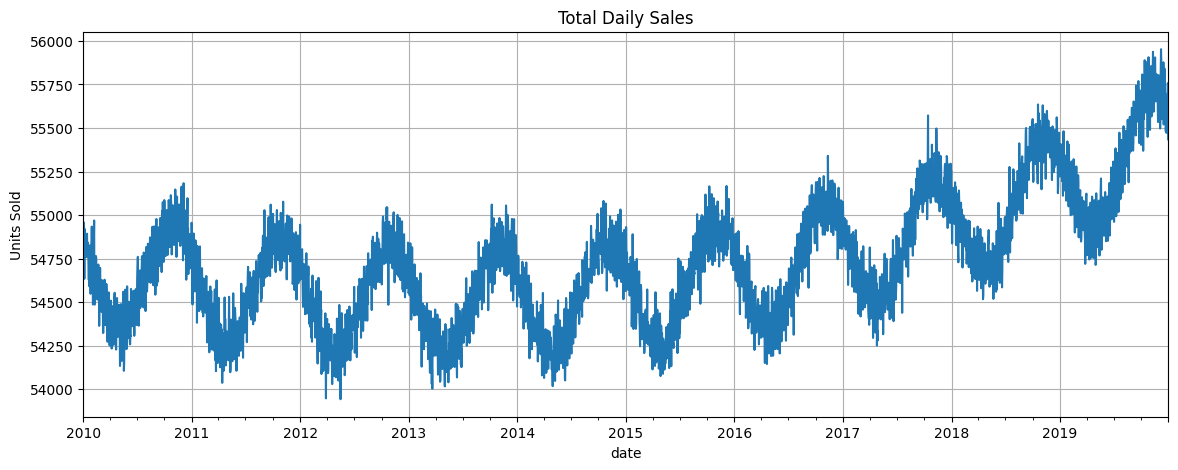

C:\Users\User001\AppData\Local\Temp\ipykernel_4676\1252106240.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_sales.index, y=product_sales.values, palette="Blues")


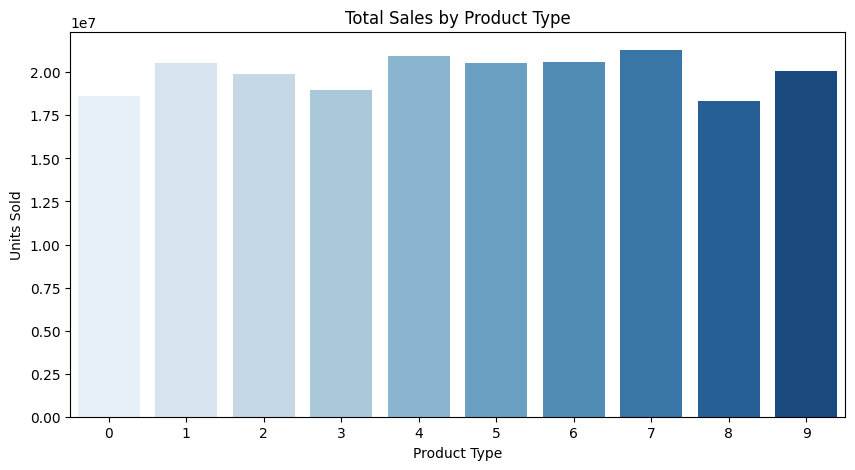

C:\Users\User001\AppData\Local\Temp\ipykernel_4676\1252106240.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stall_sales.index, y=stall_sales.values, palette="Blues")


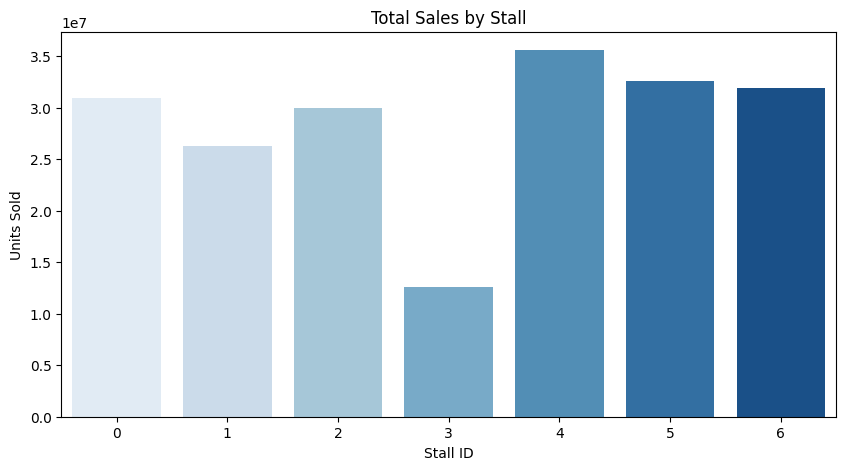

In [5]:
# Plot daily sales
plt.figure(figsize=(14,5))
daily_sales.plot()
plt.title('Total Daily Sales')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()

# Barplot: Product Types
plt.figure(figsize=(10, 5))
sns.barplot(x=product_sales.index, y=product_sales.values, palette="Blues")
plt.title("Total Sales by Product Type")
plt.xlabel("Product Type")
plt.ylabel("Units Sold")
plt.show()

# Barplot: Stall Sales
plt.figure(figsize=(10, 5))
sns.barplot(x=stall_sales.index, y=stall_sales.values, palette="Blues")
plt.title("Total Sales by Stall")
plt.xlabel("Stall ID")
plt.ylabel("Units Sold")
plt.show()

In [6]:
# Split into training (2010-2018) and test (2019)
train = daily_sales[:'2018-12-31']
test = daily_sales['2019-01-01':]

print(f"Training range: {train.index.min()} to {train.index.max()}")
print(f"Testing range: {test.index.min()} to {test.index.max()}")

Training range: 2010-01-01 00:00:00 to 2018-12-31 00:00:00
Testing range: 2019-01-01 00:00:00 to 2019-12-31 00:00:00


In [7]:
# Stationarity Test
def test_stationarity(ts):
    result = adfuller(ts)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, val in result[4].items():
        print(f'Critical Value ({key}): {val}')

test_stationarity(train)

ADF Statistic: -2.532369713456092
p-value: 0.10779573173606699
Critical Value (1%): -3.4323593525669414
Critical Value (5%): -2.8624278120183573
Critical Value (10%): -2.567242601304915


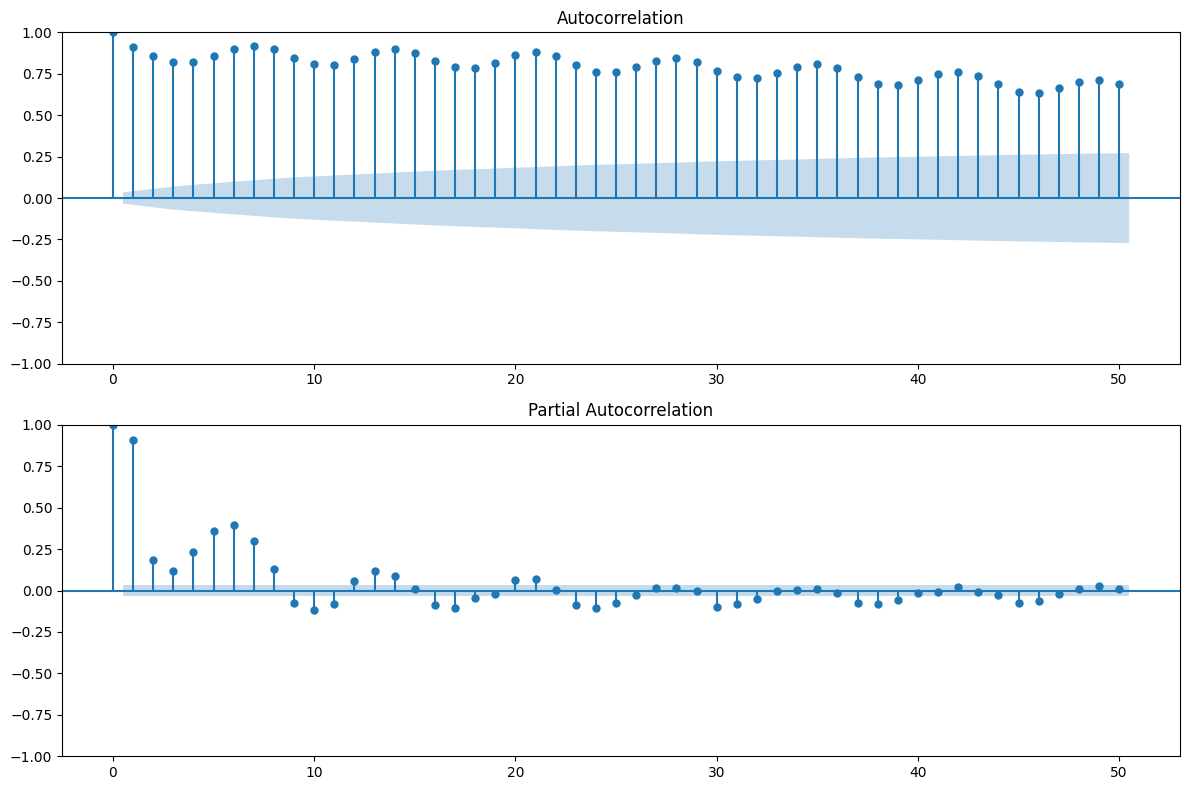

In [8]:
# ACF & PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train, lags=50, ax=ax1)
plot_pacf(train, lags=50, ax=ax2)
plt.tight_layout()
plt.show()

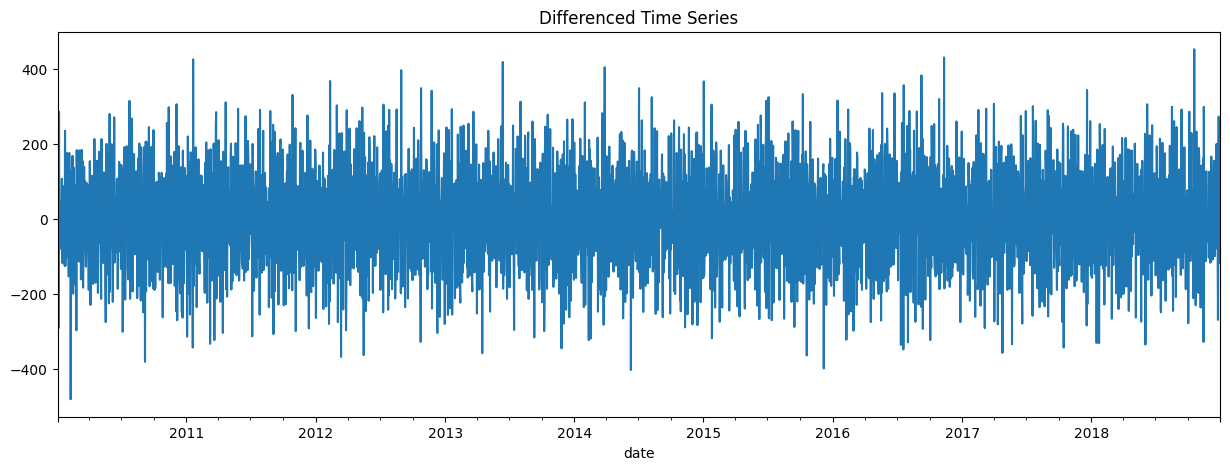

In [9]:
# Differencing to Achieve Stationarity
train_diff = train.diff().dropna()
train_diff.plot(figsize=(15,5), title="Differenced Time Series")
plt.show()

In [10]:
# ADF Test on Differenced Series
result_diff = adfuller(train_diff)
print(f'ADF Statistic: {result_diff[0]}')
print(f'p-value: {result_diff[1]}')
for key, val in result_diff[4].items():
    print(f'Critical Value ({key}): {val}')


ADF Statistic: -7.113038701555264
p-value: 3.894249829400588e-10
Critical Value (1%): -3.432359970177518
Critical Value (5%): -2.862428084811229
Critical Value (10%): -2.5672427465340872


In [11]:
# Fit SARIMA Model 
model_sarima = SARIMAX(train, 
                      order=(1,1,1), 
                      seasonal_order=(1,1,1,7))  
model_sarima_fit = model_sarima.fit()

# Summary of SARIMA
print("\nSARIMA Model Summary:")
print(model_sarima_fit.summary())

# Forecast using SARIMA
forecast_sarima = model_sarima_fit.get_forecast(steps=len(test))
forecast_values = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()
forecast_values.index = test.index


SARIMA Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                       number_sold   No. Observations:                 3287
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -19429.804
Date:                           Sat, 05 Jul 2025   AIC                          38869.608
Time:                                   22:39:31   BIC                          38900.085
Sample:                               01-01-2010   HQIC                         38880.521
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0122      0.019     -0.634      0.526      -0.050       0.025
ma.L1         -0.803

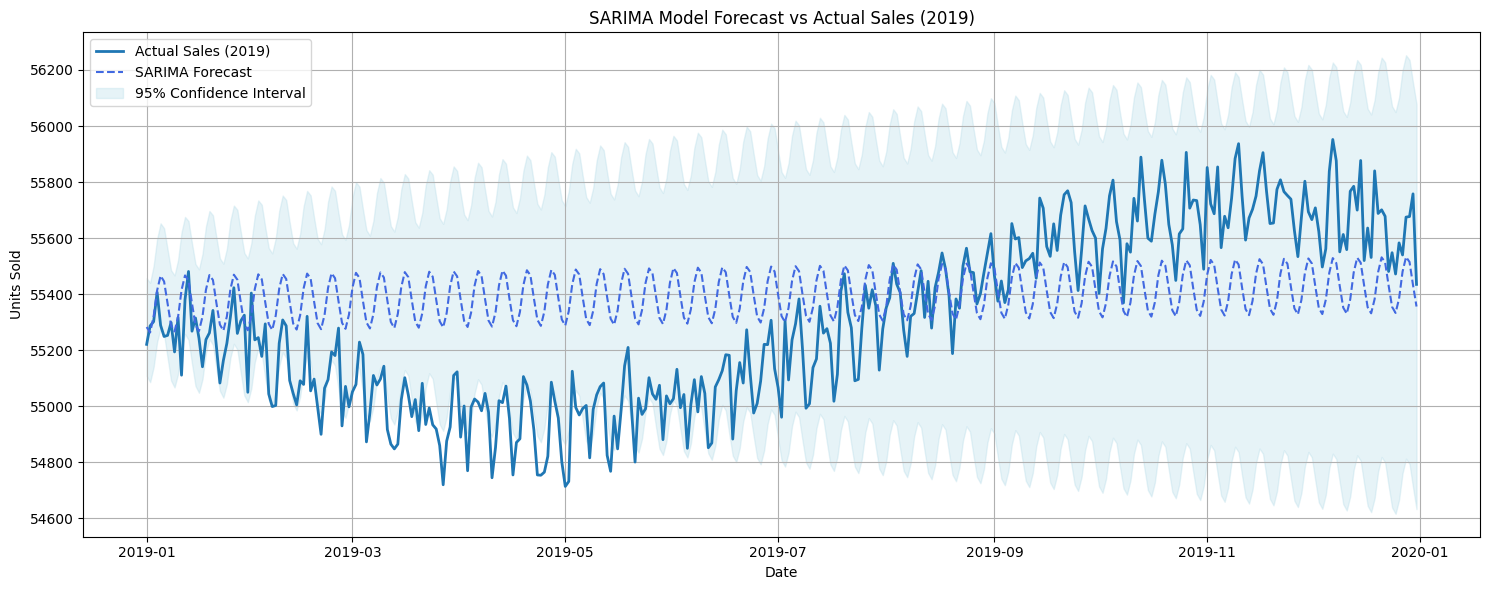

In [12]:
# SARIMA Forecast Plot
plt.figure(figsize=(15,6))
plt.plot(test.index, test, label='Actual Sales (2019)', linewidth=2)
plt.plot(forecast_values.index, forecast_values, label='SARIMA Forecast', linestyle='--', color='royalblue')
plt.fill_between(forecast_values.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='lightblue', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Model Forecast vs Actual Sales (2019)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Fit ARIMA Model
model_arima = ARIMA(train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()
print("\nARIMA Model Summary:")
print(model_arima_fit.summary())

# Forecast with ARIMA
forecast_arima_values = model_arima_fit.get_forecast(steps=len(test)).predicted_mean
forecast_arima_values.index = test.index

c:\Users\User001\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                 3287
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20210.113
Date:                Sat, 05 Jul 2025   AIC                          40426.226
Time:                        22:39:32   BIC                          40444.518
Sample:                    01-01-2010   HQIC                         40432.775
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3288      0.021     15.683      0.000       0.288       0.370
ma.L1         -0.8905      0.010    -86.414      0.000      -0.911      -0.870
sigma2      1.278e+04    323.0

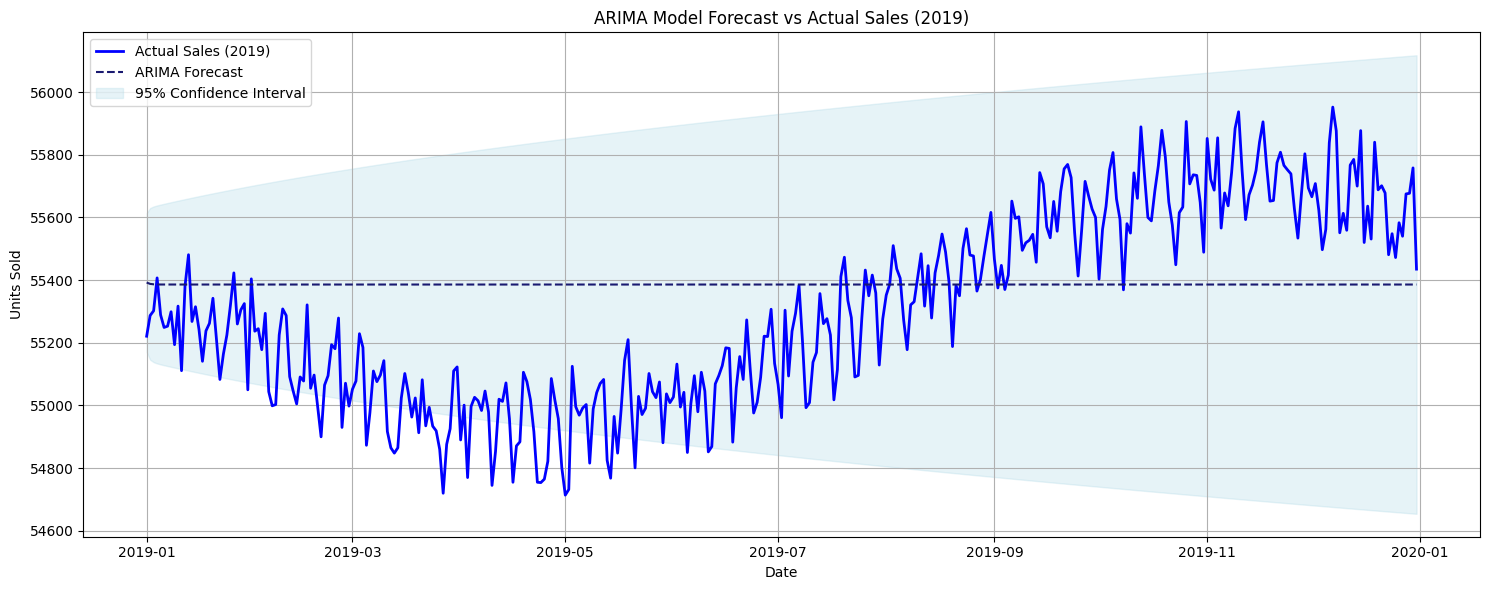

In [14]:
# ARIMA forecast
conf_int_arima = model_arima_fit.get_forecast(steps=len(test)).conf_int()
conf_int_arima.index = test.index  # Align index

# Plot ARIMA Forecast vs Actual
plt.figure(figsize=(15,6))
plt.plot(test.index, test, label='Actual Sales (2019)', linewidth=2, color='blue')
plt.plot(forecast_arima_values.index, forecast_arima_values, label='ARIMA Forecast', linestyle='--', color='midnightblue')
plt.fill_between(forecast_arima_values.index,
                 conf_int_arima.iloc[:, 0],
                 conf_int_arima.iloc[:, 1],
                 color='lightblue', alpha=0.3, label='95% Confidence Interval')
plt.title('ARIMA Model Forecast vs Actual Sales (2019)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Fit HOLT-WINTERS Model
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
model_hw_fit = model_hw.fit()

# Forecast using Holt-Winters
forecast_hw = model_hw_fit.forecast(steps=len(test))
forecast_hw.index = test.index

c:\Users\User001\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


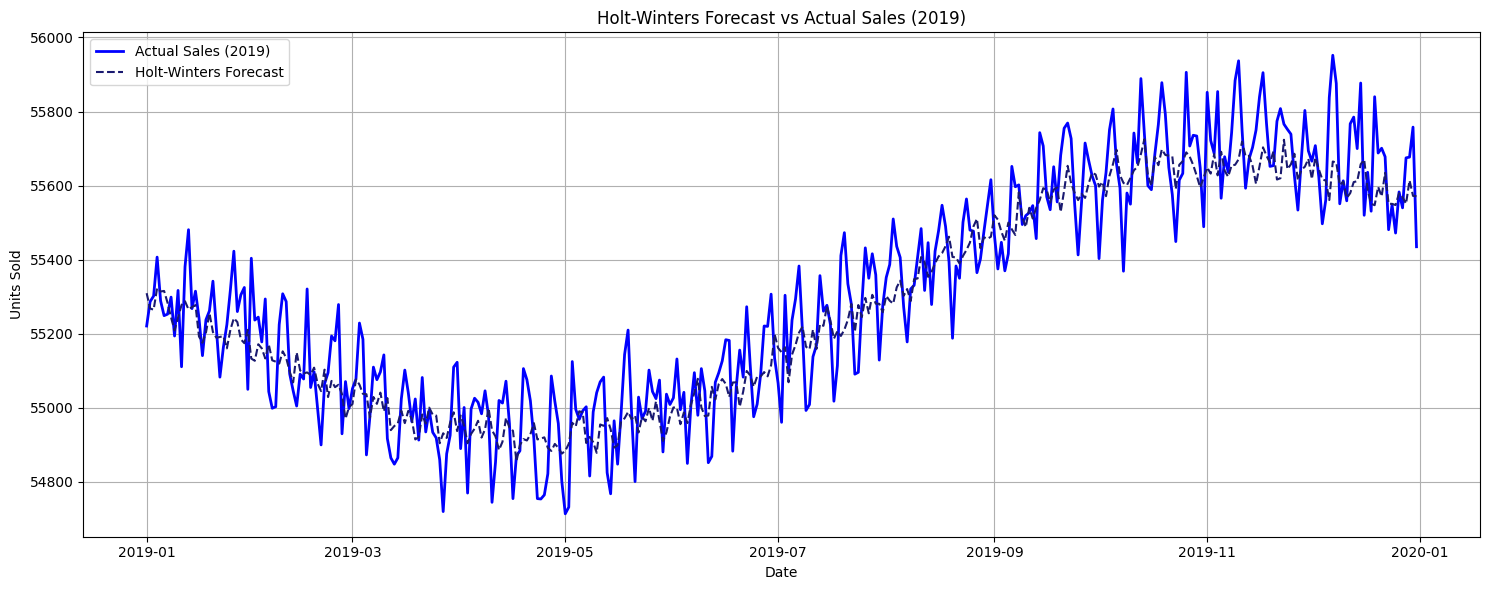

In [16]:
# Plot Holt-Winters Forecast vs Actual
plt.figure(figsize=(15,6))
plt.plot(test.index, test, label='Actual Sales (2019)', linewidth=2, color='blue')
plt.plot(forecast_hw.index, forecast_hw, label='Holt-Winters Forecast', linestyle='--', color='midnightblue')
plt.title('Holt-Winters Forecast vs Actual Sales (2019)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# Evaluation Metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mpe(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

def minmax_error(y_true, y_pred):
    return 1 - np.mean(np.minimum(y_true, y_pred) / np.maximum(y_true, y_pred))

In [18]:
metrics_all = {
    'ARIMA': {
        'MAE': mean_absolute_error(test, forecast_arima_values),
        'RMSE': np.sqrt(mean_squared_error(test, forecast_arima_values)),
        'MAPE (%)': mape(test, forecast_arima_values),
        'MPE (%)': mpe(test, forecast_arima_values),
        'Correlation': np.corrcoef(test, forecast_arima_values)[0,1],
        'Min-Max Error': minmax_error(test, forecast_arima_values)
    },
    'SARIMA': {
        'MAE': mean_absolute_error(test, forecast_values),
        'RMSE': np.sqrt(mean_squared_error(test, forecast_values)),
        'MAPE (%)': mape(test, forecast_values),
        'MPE (%)': mpe(test, forecast_values),
        'Correlation': np.corrcoef(test, forecast_values)[0,1],
        'Min-Max Error': minmax_error(test, forecast_values)
    },
    'Holt-Winters': {
        'MAE': mean_absolute_error(test, forecast_hw),
        'RMSE': np.sqrt(mean_squared_error(test, forecast_hw)),
        'MAPE (%)': mape(test, forecast_hw),
        'MPE (%)': mpe(test, forecast_hw),
        'Correlation': np.corrcoef(test, forecast_hw)[0,1],
        'Min-Max Error': minmax_error(test, forecast_hw)
    }
}

In [19]:
# Train Predictions
train_pred_arima = model_arima_fit.predict(start=train.index[0], end=train.index[-1])
train_pred_sarima = model_sarima_fit.predict(start=train.index[0], end=train.index[-1])
train_pred_hw = model_hw_fit.fittedvalues 

# Metrics Function
def compute_metrics(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE (%)': mape(y_true, y_pred),
        'MPE (%)': mpe(y_true, y_pred),
        'Correlation': np.corrcoef(y_true, y_pred)[0,1],
        'Min-Max Error': minmax_error(y_true, y_pred)
    }

# Collect Metrics
metrics_test = {
    'ARIMA': compute_metrics(test, forecast_arima_values),
    'SARIMA': compute_metrics(test, forecast_values),
    'Holt-Winters': compute_metrics(test, forecast_hw)
}

metrics_train = {
    'ARIMA': compute_metrics(train, train_pred_arima),
    'SARIMA': compute_metrics(train, train_pred_sarima),
    'Holt-Winters': compute_metrics(train, train_pred_hw)
}

# Create DataFrames
df_test_metrics = pd.DataFrame(metrics_test).reset_index().rename(columns={'index': 'Metric'})
df_train_metrics = pd.DataFrame(metrics_train).reset_index().rename(columns={'index': 'Metric'})

# Display Separately
print("\n Evaluation Metrics on Train Data (2010–2018):")
print(df_train_metrics.to_string(index=False))

print("\n Evaluation Metrics on Test Data (2019):")
print(df_test_metrics.to_string(index=False))


 Evaluation Metrics on Train Data (2010–2018):
       Metric      ARIMA      SARIMA  Holt-Winters
          MAE 107.465762   97.886843     94.685077
         RMSE 963.757327 1074.539191    117.342388
     MAPE (%)   0.196466    0.178911      0.173163
      MPE (%)   0.032620    0.017941      0.020882
  Correlation   0.261351    0.252685      0.926956
Min-Max Error   0.001963    0.001737      0.001730

 Evaluation Metrics on Test Data (2019):
       Metric      ARIMA     SARIMA  Holt-Winters
          MAE 274.808423 258.588053     91.034486
         RMSE 316.617345 297.040772    112.134896
     MAPE (%)   0.497452   0.468245      0.164547
      MPE (%)  -0.151980  -0.176216      0.049840
  Correlation  -0.013774   0.435660      0.935359
Min-Max Error   0.004952   0.004661      0.001644


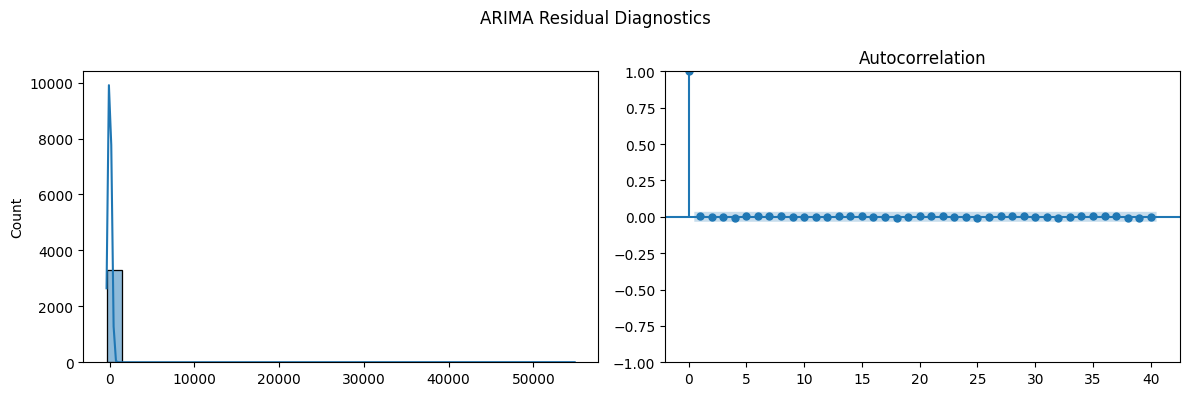

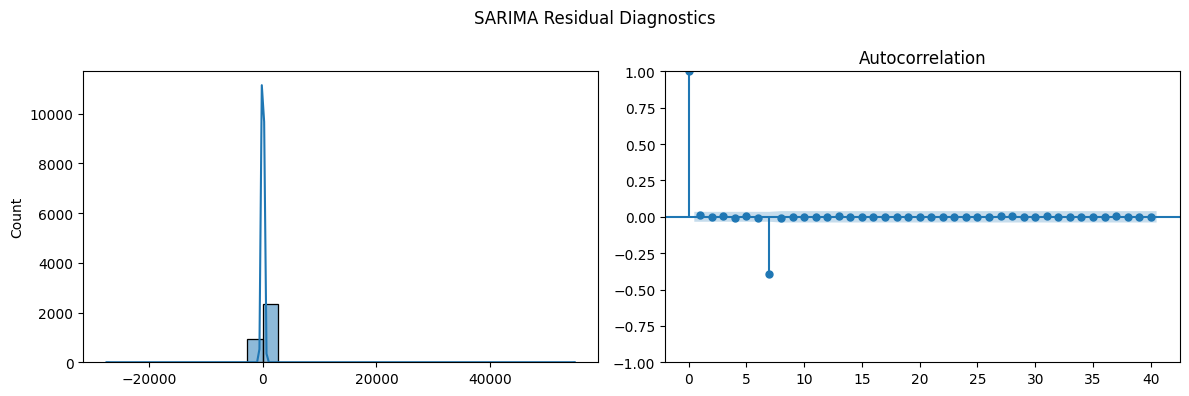

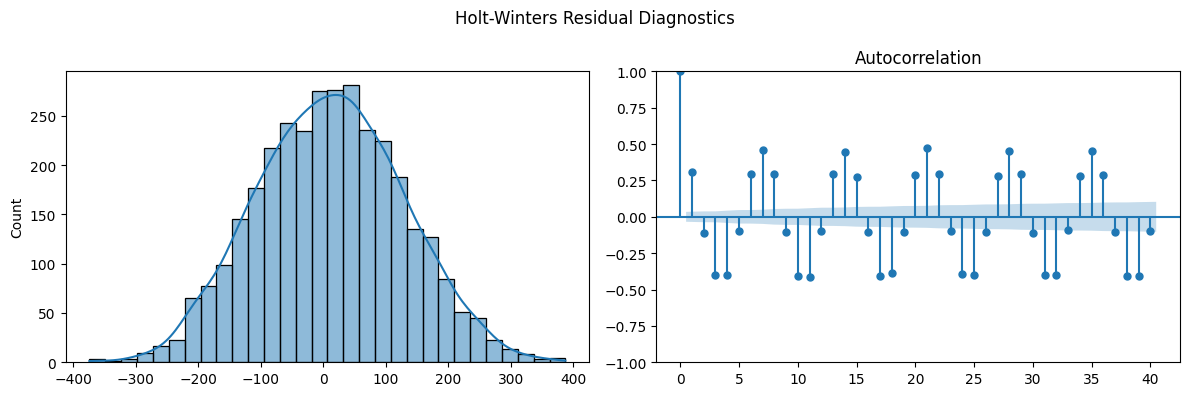

In [20]:
for model_name, residuals in {
    'ARIMA': model_arima_fit.resid,
    'SARIMA': model_sarima_fit.resid,
    'Holt-Winters': train - train_pred_hw
}.items():
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(residuals, bins=30, kde=True, ax=ax[0])
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[1])
    fig.suptitle(f'{model_name} Residual Diagnostics')
    plt.tight_layout()
    plt.show()


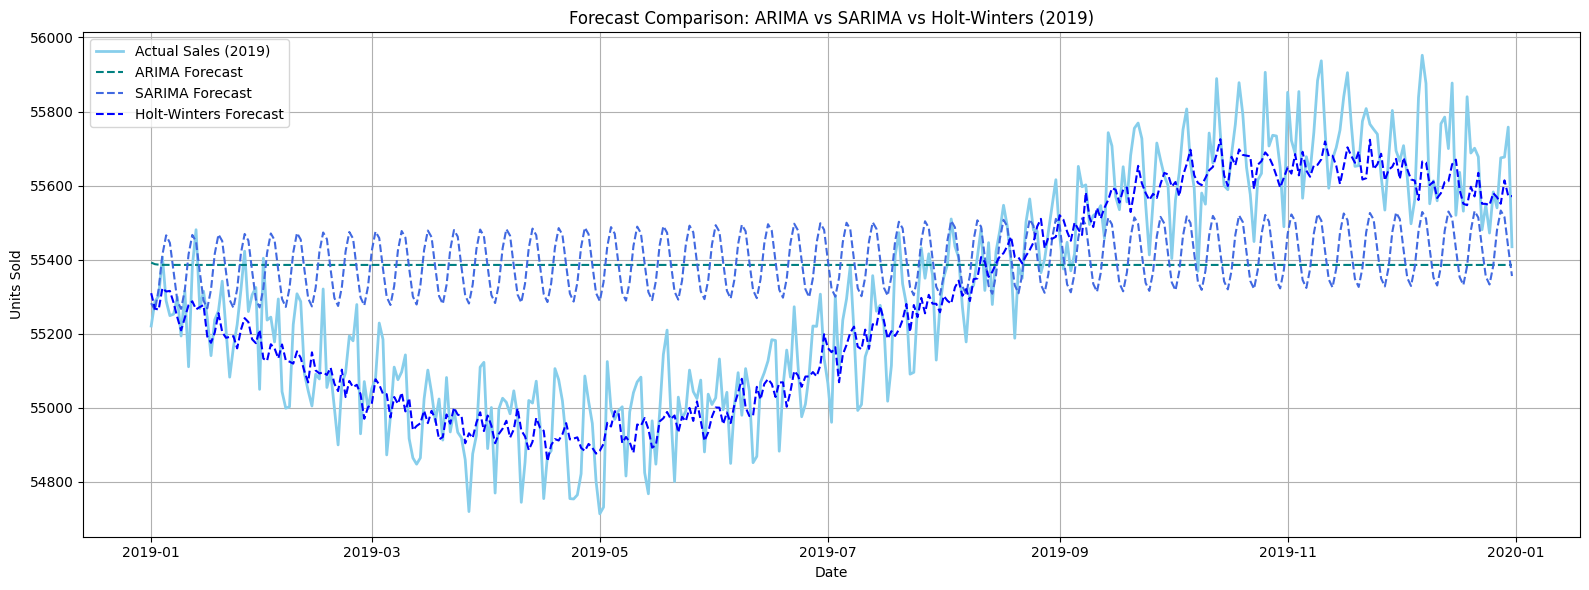

In [21]:
# Forecast Comparison
plt.figure(figsize=(16,6))
plt.plot(test.index, test, label='Actual Sales (2019)', linewidth=2, color='skyblue')
plt.plot(forecast_arima_values, label='ARIMA Forecast', linestyle='--', color='teal')
plt.plot(forecast_values, label='SARIMA Forecast', linestyle='--', color='royalblue')
plt.plot(forecast_hw, label='Holt-Winters Forecast', linestyle='--', color='blue')
plt.title("Forecast Comparison: ARIMA vs SARIMA vs Holt-Winters (2019)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

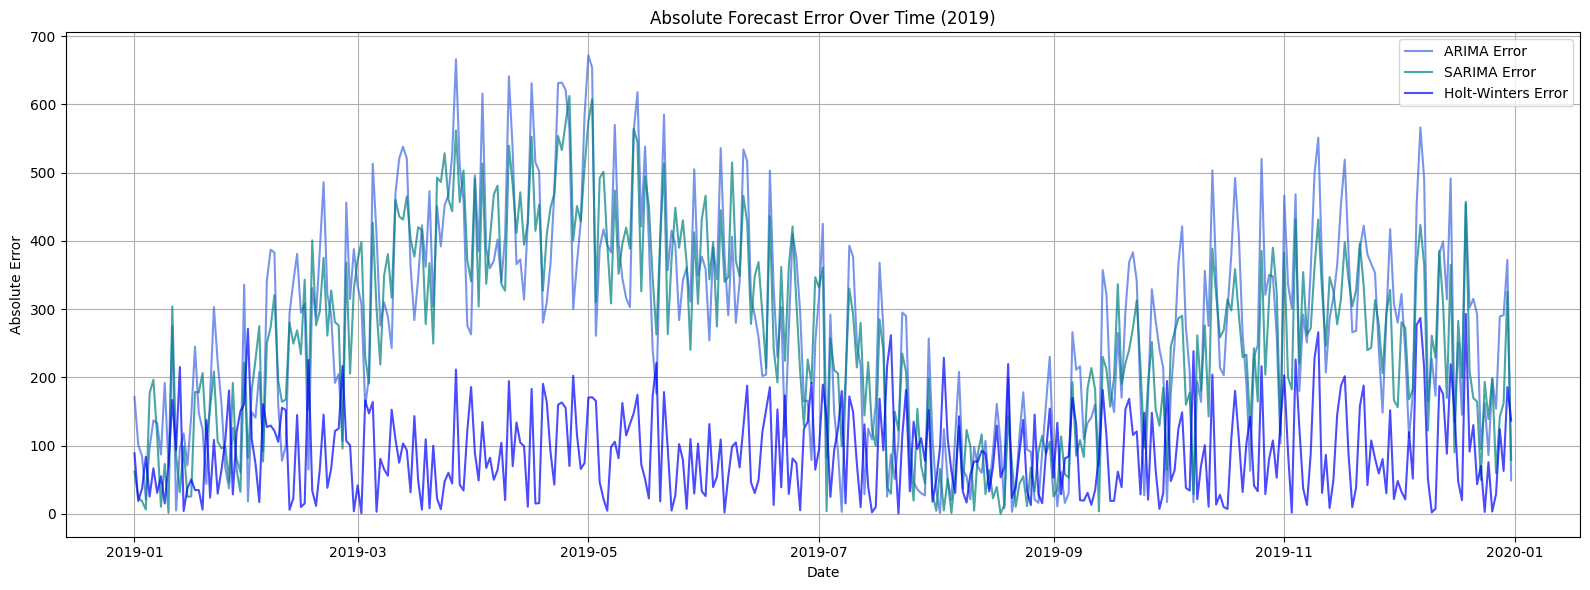

In [22]:
# Errors
abs_error_arima = np.abs(test - forecast_arima_values)
abs_error_sarima = np.abs(test - forecast_values)
abs_error_hw = np.abs(test - forecast_hw)

plt.figure(figsize=(16,6))
plt.plot(abs_error_arima.index, abs_error_arima, label='ARIMA Error', alpha=0.7, color='royalblue')
plt.plot(abs_error_sarima.index, abs_error_sarima, label='SARIMA Error', alpha=0.7, color='teal')
plt.plot(abs_error_hw.index, abs_error_hw, label='Holt-Winters Error', alpha=0.7,color='blue')
plt.title("Absolute Forecast Error Over Time (2019)")
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()